In [1]:
%matplotlib inline


Определение типа электроники
==============================================


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import requests

plt.ion()   # interactive mode

Загрузка данных из ImageNet
---------

Загрузим картинки для 11 классов в отношении **тренировка/валидация = 7/3**


In [3]:
%%script just_for_skip_123

# Загрузим картинки по ссылкам
images = {
    'microwave': 'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n03761084',
    'refrigerator': 'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n04070727',
    'washing_machine': 'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n04554684',
    'television': 'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n04404412',
    'cellphone': 'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n02992529',
    'earphone': 'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n03261776',
    'mouse': 'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n03793489',
    'keyboard': 'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n03085013',
    'remote': 'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n04074963',
    'speaker': 'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n03691459',
    'laptop': 'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n03642806',
    'ipod': 'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n03584254',
}

train_ratio = 0.7

main_path = os.getcwd() + '/lab1_data/'
if not os.path.exists(os.path.dirname(main_path)):
    os.makedirs(os.path.dirname(main_path))
if not os.path.exists(os.path.dirname(main_path + 'train/')):
    os.makedirs(os.path.dirname(main_path + 'train/'))
if not os.path.exists(os.path.dirname(main_path + 'val/')):
    os.makedirs(os.path.dirname(main_path + 'val/'))

for class_name, url in images.items():
    train_count_limit = 140
    val_count_limit = 60

    images_urls = requests.get(url)

    list = images_urls.text.split()
    list_length = len(list)

    print(f'{class_name} [{list_length}]')
    for index, image_url in enumerate(list, start=1):
        try:
            response = requests.get(image_url, timeout=1)
        except Exception as e:
            pass
        else:
            is_val = True
            if train_count_limit > 0:
                is_val = False
                save_path = main_path + f'train/{class_name}/'
            elif val_count_limit > 0:
                save_path = main_path + f'val/{class_name}/'
            else:
                break

            if not os.path.exists(os.path.dirname(save_path)):
                os.makedirs(os.path.dirname(save_path))

            if response.headers.get('Content-Type', '') == 'image/jpeg':
                with open(f'{save_path}{index}.jpg', 'wb') as handler:
                    handler.write(response.content)
                    if is_val:
                        val_count_limit -= 1
                    else:
                        train_count_limit -= 1

                print(f'{train_count_limit} / {val_count_limit}')
    print(f'-------\n')
print('Загрузка завершена')

Couldn't find program: 'just_for_skip_123'


Инициализация данных
---------

Зададим трансформации, подгрузим изображения и выберем девайс для вычислений

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
custom_data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.3, 0.3, 0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

half_data_dir = 'lab1_data/full'
full_data_dir = 'lab1_data/half'
part_image_datasets = {x: datasets.ImageFolder(os.path.join(half_data_dir, x),
                                               data_transforms[x]) for x in ['train', 'val']}
part_image_datasets_more_transforms = {x: datasets.ImageFolder(os.path.join(half_data_dir, x),
                                                               custom_data_transforms[x]) for x in ['train', 'val']}
full_image_datasets = {x: datasets.ImageFolder(os.path.join(full_data_dir, x),
                                               data_transforms[x]) for x in ['train', 'val']}

part_dataloader = {x: torch.utils.data.DataLoader(part_image_datasets[x], batch_size=4,
                                                  shuffle=True, num_workers=4) for x in ['train', 'val']}
part_dataloader_more_transforms = {x: torch.utils.data.DataLoader(part_image_datasets_more_transforms[x], batch_size=4,
                                                               shuffle=True, num_workers=4) for x in ['train', 'val']}
full_dataloader = {x: torch.utils.data.DataLoader(full_image_datasets[x], batch_size=4,
                                                  shuffle=True, num_workers=4) for x in ['train', 'val']}

class_names = full_image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

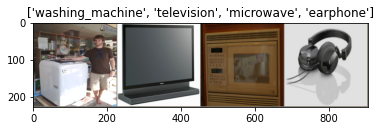

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(part_dataloader_more_transforms['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model_data, num_epochs):
    model = model_data['model']
    dataloader = model_data['dataloader']
    criterion = model_data['criterion']
    optimizer = model_data['optimizer']
    scheduler = model_data['scheduler']

    t_loss = []
    v_loss = []
    t_acc = []
    v_acc = []

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloader[phase].dataset)
            
            if phase == 'train':
                t_loss.append(epoch_loss)
                t_acc.append(epoch_acc)
            else:
                v_loss.append(epoch_loss)
                v_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))
    print('=' * 15, '\n')

    # load best model weights
    # model.load_state_dict(best_model_wts)

    model_data['t_loss'] = t_loss
    model_data['v_loss'] = v_loss
    model_data['t_acc'] = [item.tolist() for item in t_acc]
    model_data['v_acc'] = [item.tolist() for item in v_acc]

In [7]:
# Визуализация предсказаний
def visualize_model(model_data, num_images=6):
    model = model_data['model']
    dataloader = model_data['dataloader']

    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Настройка модели
----------------------

In [8]:
def get_new_model(freeze_layers=False):
    model = torchvision.models.resnet18(pretrained=True)
    if freeze_layers:
        for param in model.parameters():
            param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_names))
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    return model, criterion, optimizer, exp_lr_scheduler

In [22]:
def make_plot(x, y_list, x_label, y_label, title, legend):
        for y in y_list:
            plt.plot(x, y)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.legend(legend)
        plt.show()
        
def show_plots(only_comparison=False):
    t_loss_list = []
    v_loss_list = []
    t_acc_list = []
    v_acc_list = []
    best_t_loss_list = []
    best_v_loss_list = []
    best_t_acc_list = []
    best_v_acc_list = []

    for model_data in custom_models:
        model_name = model_data['name']

        x = []
        t_loss = []
        v_loss = []
        t_acc = []
        v_acc = []
        best_t_loss = []
        best_v_loss = []
        best_t_acc = []
        best_v_acc = []

        for epochs_limit in range(1, epochs_count):
            x.append(epochs_limit)
            t_loss.append(model_data['t_loss'][epochs_limit])
            v_loss.append(model_data['v_loss'][epochs_limit])
            t_acc.append(model_data['t_acc'][epochs_limit])
            v_acc.append(model_data['v_acc'][epochs_limit])

            best_t_loss.append(min(model_data['t_loss'][:epochs_limit]))
            best_v_loss.append(min(model_data['v_loss'][:epochs_limit]))
            best_t_acc.append(max(model_data['t_acc'][:epochs_limit]))
            best_v_acc.append(max(model_data['v_acc'][:epochs_limit]))

        t_loss_list.append(t_loss)
        v_loss_list.append(v_loss)
        t_acc_list.append(t_acc)
        v_acc_list.append(v_acc)

        best_t_loss_list.append(best_t_loss)
        best_v_loss_list.append(best_v_loss)
        best_t_acc_list.append(best_t_acc)
        best_v_acc_list.append(best_v_acc)

        if not only_comparison:
            make_plot(x, [t_loss, v_loss], 'epochs', 'loss', f'loss ({model_name})', ['train', 'val'])
            make_plot(x, [t_acc, v_acc], 'epochs', 'accuracy', f'accuracy ({model_name})', ['train', 'val'])

    model_names = [model_data['name'] for model_data in custom_models]    

    make_plot(x, t_loss_list, 'epochs', 'loss', 'train loss', model_names)
    make_plot(x, v_loss_list, 'epochs', 'loss', 'val loss', model_names)
    make_plot(x, t_acc_list, 'epochs', 'accuracy', 'train accuracy', model_names)
    make_plot(x, v_acc_list, 'epochs', 'accuracy', 'val accuracy', model_names)

    make_plot(x, best_t_loss_list, 'epochs', 'loss', 'best train loss', model_names)
    make_plot(x, best_v_loss_list, 'epochs', 'loss', 'best val loss', model_names)
    make_plot(x, best_t_acc_list, 'epochs', 'accuracy', 'best train accuracy', model_names)
    make_plot(x, best_v_acc_list, 'epochs', 'accuracy', 'best val accuracy', model_names)

In [13]:
model_1 = {
    'name': '70 train images',
    'dataloader': part_dataloader,
}
model_1['model'], model_1['criterion'], model_1['optimizer'], model_1['scheduler'] = get_new_model(freeze_layers=False)

model_2 = {
    'name': '70 train images (custom transforms)',
    'dataloader': part_dataloader_more_transforms,
}
model_2['model'], model_2['criterion'], model_2['optimizer'], model_2['scheduler'] = get_new_model(freeze_layers=False)

model_3 = {
    'name': '140 train images',
    'dataloader': full_dataloader,
}
model_3['model'], model_3['criterion'], model_3['optimizer'], model_3['scheduler'] = get_new_model(freeze_layers=False)

custom_models = [model_1, model_2, model_3]
epochs_count = 25

for model_data in custom_models:
    train_model(model_data, epochs_count)

show_plots()


Epoch 0/24
----------
train Loss: 1.8449 Acc: 0.3836
val Loss: 0.9901 Acc: 0.6995

Epoch 1/24
----------
train Loss: 1.3502 Acc: 0.5566
val Loss: 0.7152 Acc: 0.7739

Epoch 2/24
----------
train Loss: 1.3026 Acc: 0.5904
val Loss: 0.7295 Acc: 0.7845

Epoch 3/24
----------
train Loss: 1.2298 Acc: 0.6235
val Loss: 0.6150 Acc: 0.8012

Epoch 4/24
----------
train Loss: 1.1770 Acc: 0.6242
val Loss: 0.6010 Acc: 0.8149

Epoch 5/24
----------
train Loss: 1.2132 Acc: 0.6112
val Loss: 0.7352 Acc: 0.7891

Epoch 6/24
----------
train Loss: 1.2154 Acc: 0.6261
val Loss: 0.7304 Acc: 0.7785

Epoch 7/24
----------
train Loss: 0.9945 Acc: 0.6814
val Loss: 0.6306 Acc: 0.8194

Epoch 8/24
----------
train Loss: 0.9692 Acc: 0.6951
val Loss: 0.6068 Acc: 0.8240

Epoch 9/24
----------
train Loss: 1.0015 Acc: 0.6827
val Loss: 0.5966 Acc: 0.8149

Epoch 10/24
----------
train Loss: 0.9782 Acc: 0.6977
val Loss: 0.6174 Acc: 0.8134

Epoch 11/24
----------
train Loss: 1.0154 Acc: 0.6762
val Loss: 0.5682 Acc: 0.8240

E

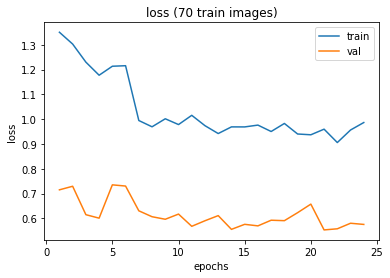

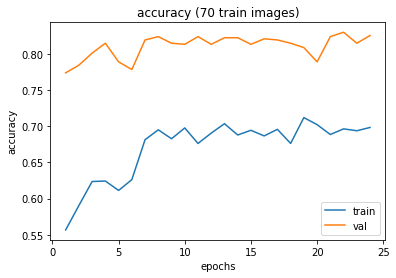

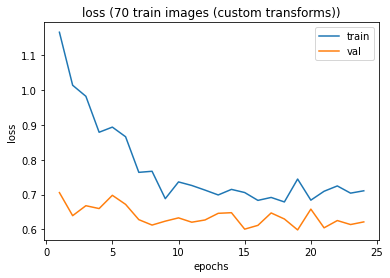

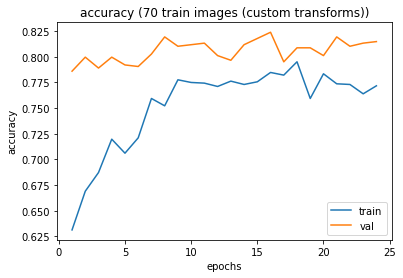

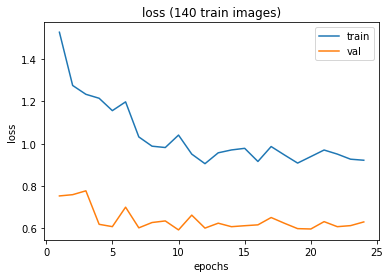

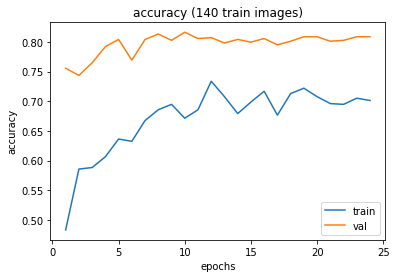

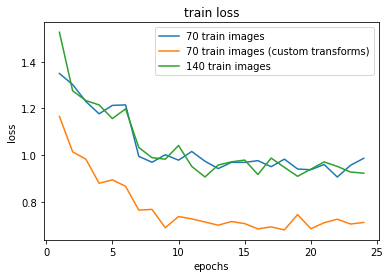

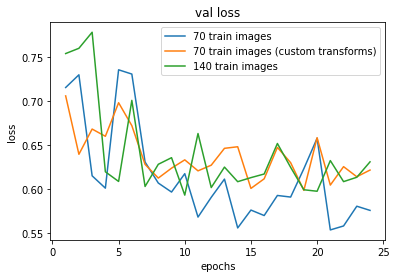

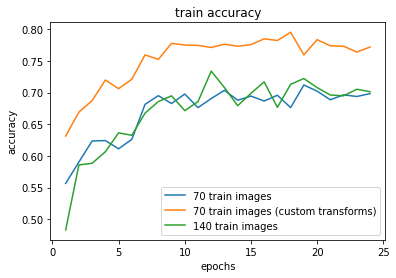

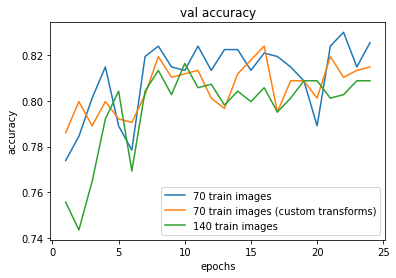

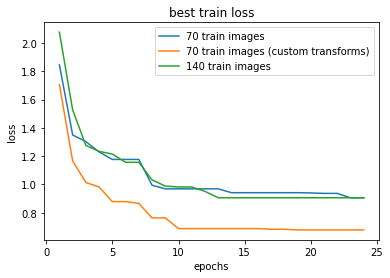

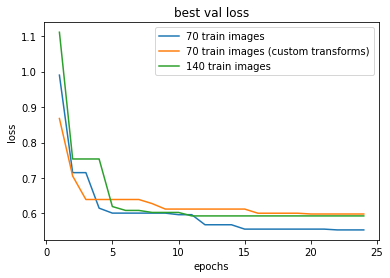

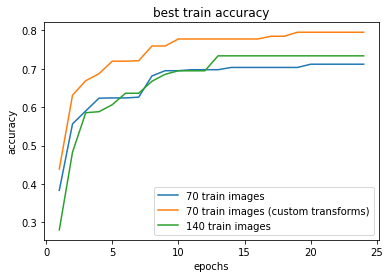

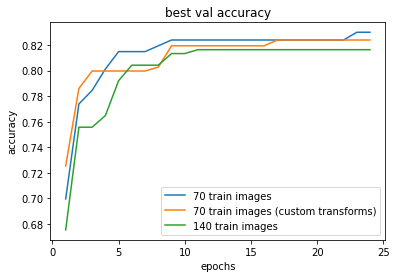

In [23]:
show_plots()


Epoch 0/24
----------
train Loss: 1.8739 Acc: 0.3700
val Loss: 0.7610 Acc: 0.7663

Epoch 1/24
----------
train Loss: 1.3304 Acc: 0.5741
val Loss: 0.6594 Acc: 0.7982

Epoch 2/24
----------
train Loss: 1.3492 Acc: 0.5702
val Loss: 0.6160 Acc: 0.8164

Epoch 3/24
----------
train Loss: 1.1752 Acc: 0.6294
val Loss: 0.6470 Acc: 0.7936

Epoch 4/24
----------
train Loss: 1.2049 Acc: 0.6177
val Loss: 0.6231 Acc: 0.8042

Epoch 5/24
----------
train Loss: 1.0870 Acc: 0.6515
val Loss: 0.6106 Acc: 0.8027

Epoch 6/24
----------
train Loss: 1.1809 Acc: 0.6261
val Loss: 0.6339 Acc: 0.8149

Epoch 7/24
----------
train Loss: 1.0234 Acc: 0.6736
val Loss: 0.5729 Acc: 0.8179

Epoch 8/24
----------
train Loss: 1.0033 Acc: 0.6866
val Loss: 0.6080 Acc: 0.8179

Epoch 9/24
----------
train Loss: 0.9951 Acc: 0.6684
val Loss: 0.5852 Acc: 0.8149

Epoch 10/24
----------
train Loss: 0.9997 Acc: 0.6788
val Loss: 0.5749 Acc: 0.8285

Epoch 11/24
----------
train Loss: 1.0128 Acc: 0.6788
val Loss: 0.5606 Acc: 0.8300

E

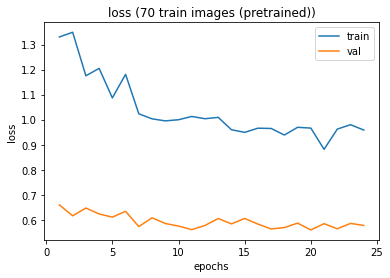

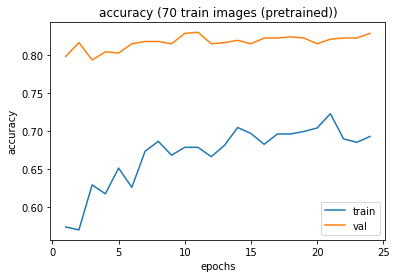

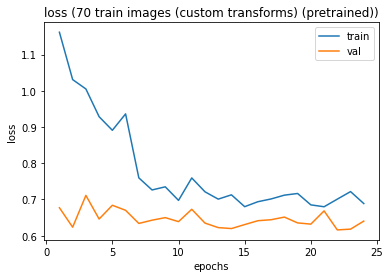

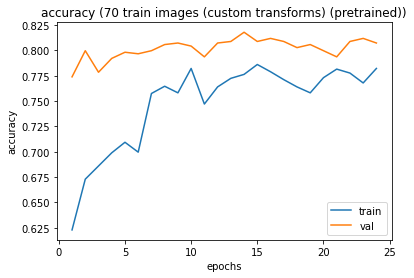

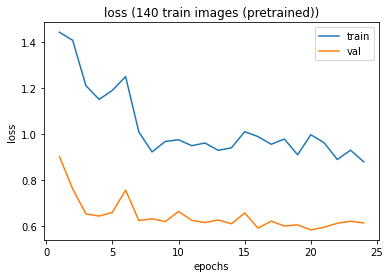

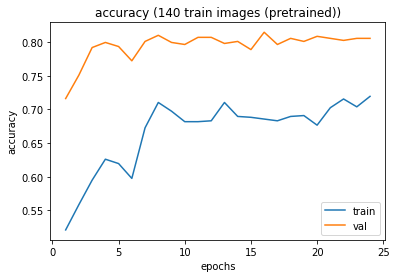

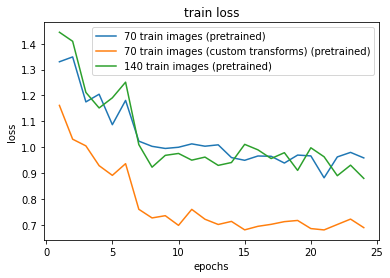

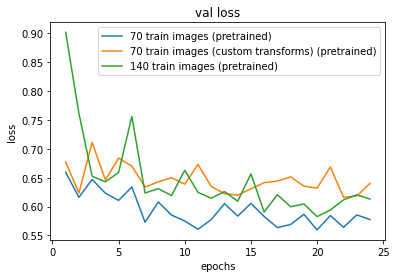

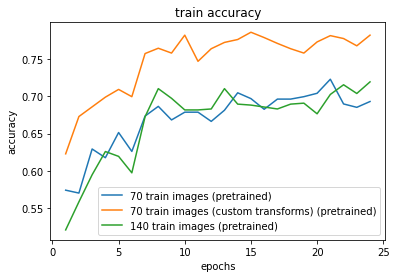

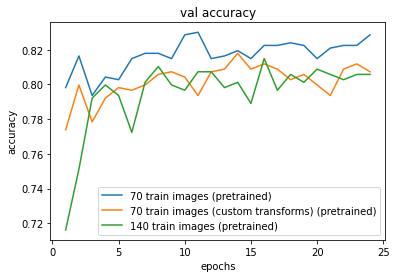

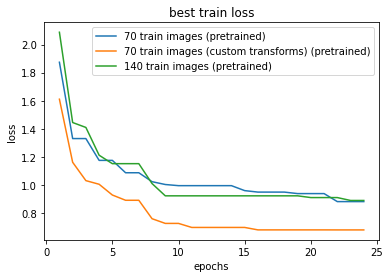

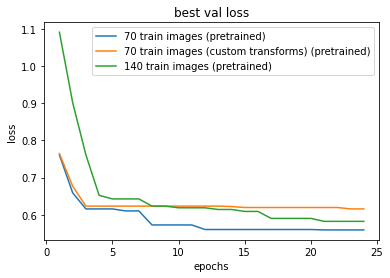

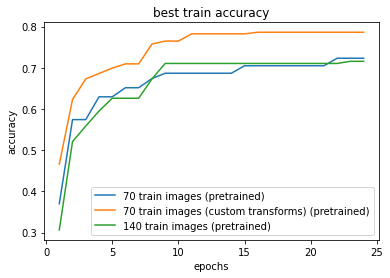

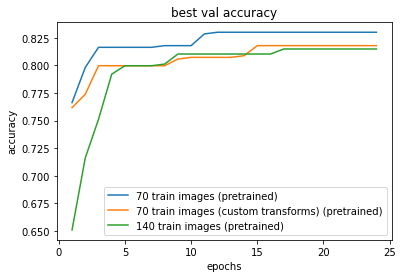

In [24]:
model_4 = {
    'name': '70 train images (pretrained)',
    'dataloader': part_dataloader,
}
model_4['model'], model_4['criterion'], model_4['optimizer'], model_4['scheduler'] = get_new_model(freeze_layers=True)

model_5 = {
    'name': '70 train images (custom transforms) (pretrained)',
    'dataloader': part_dataloader_more_transforms,
}
model_5['model'], model_5['criterion'], model_5['optimizer'], model_5['scheduler'] = get_new_model(freeze_layers=True)

model_6 = {
    'name': '140 train images (pretrained)',
    'dataloader': full_dataloader,
}
model_6['model'], model_6['criterion'], model_6['optimizer'], model_6['scheduler'] = get_new_model(freeze_layers=True)

custom_models = [model_4, model_5, model_6]
epochs_count = 25

for model_data in custom_models:
    train_model(model_data, epochs_count)
    
show_plots()

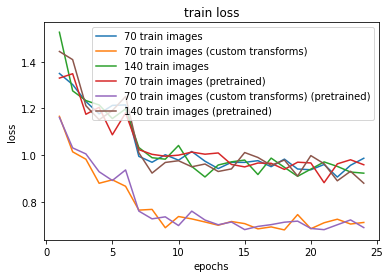

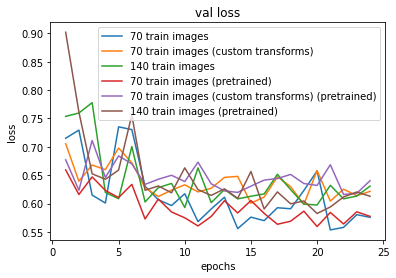

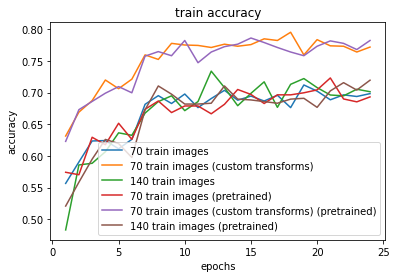

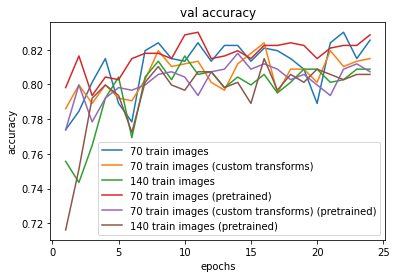

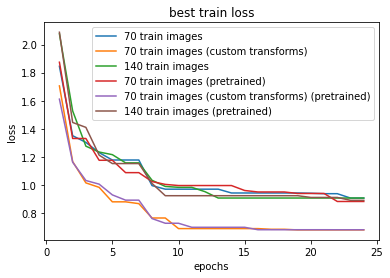

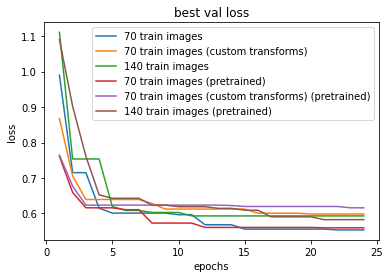

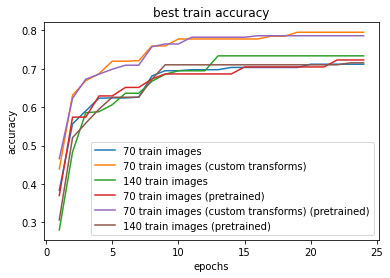

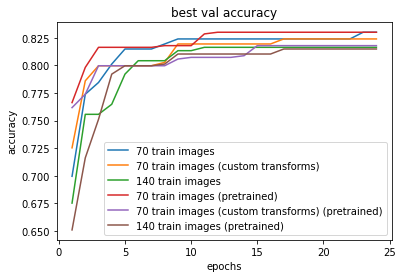

In [25]:
custom_models = [model_1, model_2, model_3, model_4, model_5, model_6]
show_plots(only_comparison=True)